Example file which shows some simple curve fitting using BMSRegressor and some other estimators.

In [ ]:
# Uncomment the following line when running on Google Colab
# !pip install autora

In [21]:
from functools import partial

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from autora.skl.bms import BMSRegressor
from autora.synthetic import retrieve

In [22]:
def show_results_complete(
    data_: pd.DataFrame,
    estimator=None,
    show_results=True,
    projection="2d",
    label=None,
):
    """
    Function to plot input data (x_, y_) and the predictions of an estimator for the same x_.
    """
    if projection == "2d":
        plt.figure()
        data_.plot.scatter(
            "S1", "S2", c="difference_detected", cmap="viridis", zorder=10
        )
    elif projection == "3d":
        fig = plt.figure()
        ax = fig.add_subplot(projection="3d")
        ax.scatter(data_["S1"], data["S2"], data["difference_detected"])
        if estimator is not None:
            xs, ys = np.mgrid[0:5:0.2, 0:5:0.2]  # type: ignore
            zs = estimator.predict(np.column_stack((xs.ravel(), ys.ravel())))
            ax.plot_surface(xs, ys, zs.reshape(xs.shape), alpha=0.5)

    if label is not None:
        plt.title(label)

    if show_results:
        plt.show()

    return

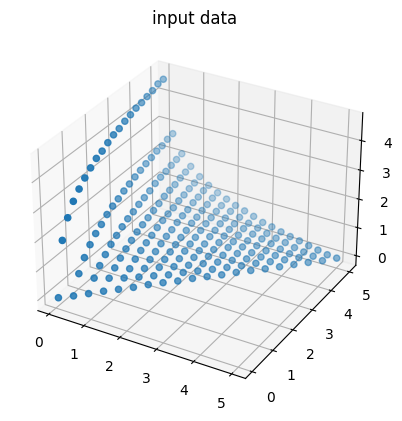

In [28]:
# %% Load the data
s = retrieve("weber_fechner",rng=np.random.default_rng(seed=180), resolution=20)
X_ = s.domain()
y_ = s.experiment_runner(X_)
data = pd.DataFrame(np.column_stack([X_, y_]), columns=["S1", "S2", "difference_detected"])
show_results = partial(show_results_complete, data_=data, projection="3d")
show_results(label="input data")
X, y = data[["S1", "S2"]], data["difference_detected"]

/Users/jholla10/Library/Caches/pypoetry/virtualenvs/autora-17yK3Jyq-py3.8/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


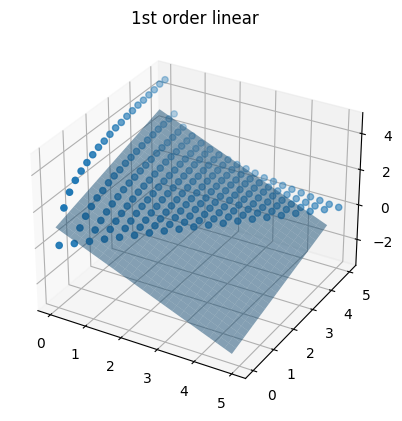

In [29]:
# %% Fit first using a super-simple linear regression

first_order_linear_estimator = LinearRegression()
first_order_linear_estimator.fit(X, y)

show_results(estimator=first_order_linear_estimator, label="1st order linear")

/Users/jholla10/Library/Caches/pypoetry/virtualenvs/autora-17yK3Jyq-py3.8/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


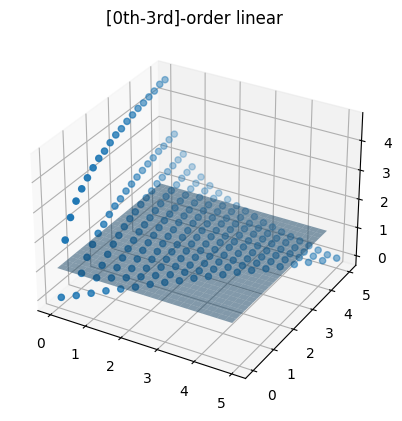

In [30]:
# %% Fit using a 0-3 order polynomial, getting the best fit for the data.
polynomial_estimator = GridSearchCV(
    make_pipeline(PolynomialFeatures(), LinearRegression(fit_intercept=False)),
    param_grid=dict(polynomialfeatures__degree=range(4)),
)
polynomial_estimator.fit(X, y)

show_results(estimator=polynomial_estimator, label="[0th-3rd]-order linear")

INFO:autora.skl.bms:BMS fitting started
  0%|          | 7/1500 [00:00<01:15, 19.80it/s]<lambdifygenerated-109678>:2: RuntimeWarning: invalid value encountered in power
  return S2**2*_a0_**S1
<lambdifygenerated-109686>:2: RuntimeWarning: invalid value encountered in power
  return -_a0_**S2
<lambdifygenerated-109687>:2: RuntimeWarning: invalid value encountered in power
  return -_a0_**S2
<lambdifygenerated-109688>:2: RuntimeWarning: invalid value encountered in power
  return -_a0_**S2
<lambdifygenerated-109689>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(cos(S1))
<lambdifygenerated-109690>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(cos(S1))
<lambdifygenerated-109691>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(cos(S1))
<lambdifygenerated-109719>:2: RuntimeWarning: invalid value encountered in power
  return _a0_**S1/S2
<lambdifygenerated-109743>:2: RuntimeWarning: invalid value encountered in log
  return log(S1/_

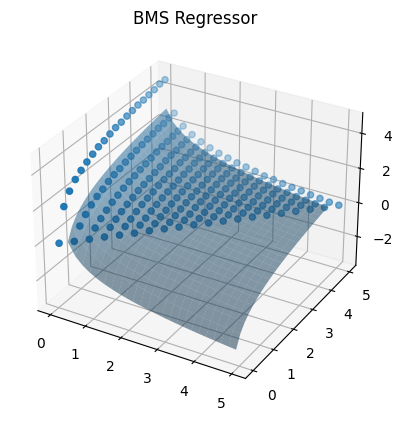

log((S2 / S1))


array([[0.        ],
       [1.82624565],
       [2.43545837],
       [2.81130323],
       [3.08383954]])

In [31]:
# initialize model
# hyper parameters

prior_par = {
    "Nopi_/": 5.912205942815285,
    "Nopi_cosh": 8.12720511103694,
    "Nopi_-": 3.350846072163632,
    "Nopi_sin": 5.965917796154835,
    "Nopi_tan": 8.127427922862411,
    "Nopi_tanh": 7.799259068142255,
    "Nopi_**": 6.4734429542245495,
    "Nopi_pow2": 3.3017352779079734,
    "Nopi_pow3": 5.9907496760026175,
    "Nopi_exp": 4.768665265735502,
    "Nopi_log": 4.745957377206544,
    "Nopi_sqrt": 4.760686909134266,
    "Nopi_cos": 5.452564657261127,
    "Nopi_sinh": 7.955723540761046,
    "Nopi_abs": 6.333544134938385,
    "Nopi_+": 5.808163661224514,
    "Nopi_*": 5.002213595420244,
    "Nopi_fac": 10.0,
    "Nopi2_*": 1.0,
    "Nopi_sig": 1.0,
    "Nopi_relu": 1.0,
}

# temperatures
ts = [1.0] + [1.04**k for k in range(1, 20)]

# epoch num
epochs = 1500

# fit model
estimator = BMSRegressor(prior_par, ts, epochs)
estimator = estimator.fit(X, y)

# model estimate
show_results(
    estimator=estimator, label="BMS Regressor"
)
print(estimator.model_)

# model prediction
test_x = X.head()
estimator.predict(test_x)

Best model:	 log((S2 / S1))
Desc. length:	 -659.941451339323


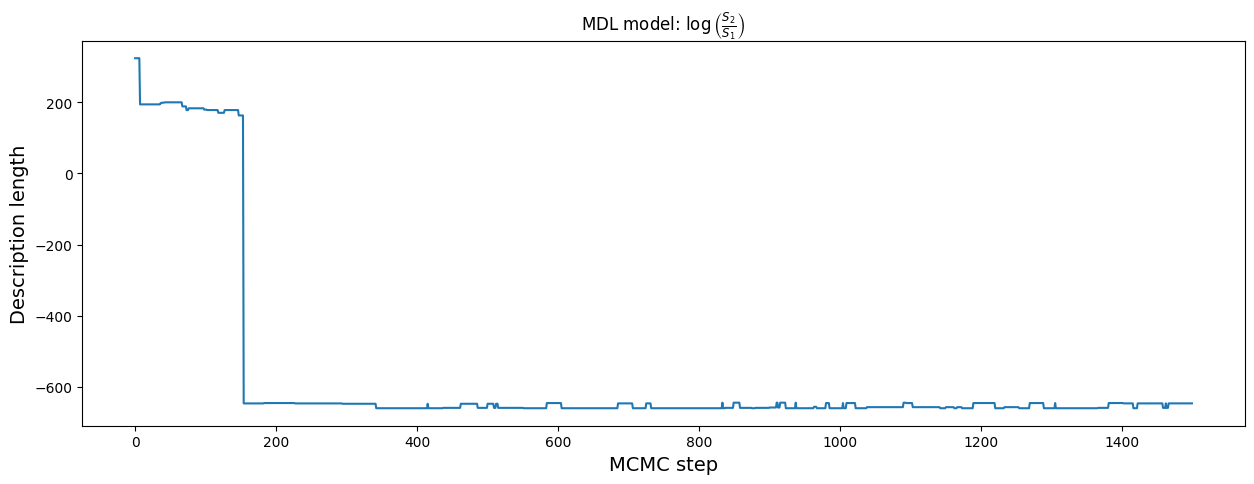

In [32]:
estimator.present_results()